# Read before
Install pyFAI library for azimuthal integration from https://pyfai.readthedocs.io/en/master/ and the documentation there in

In [11]:
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
import math

In [12]:
#Defining experiment parameters
KE = 50 #kinetic energy of electrons kev
planck_c = 4.135667516e-15 #planck constant
m0 = 9.10938215e-31 #rest mass of electron
speed_light = 299792458 #Speed of light
lambda_e = (planck_c*speed_light/(math.sqrt(KE*1000*(KE*1000+2*m0*speed_light**2*6.241506363e+18)))); 
print("Electron beam wavelength = {} m".format(lambda_e))

#Defining the detector parameters this can be adapted from the experiment
xcen = 391.55 #center of the diffraction
ycen = 393.03 #center of the diffraction
pixel_size = 4.8e-5 #size of the pixel
shape_det = [900,900]
distanceDet = 0.5 # in m 
wavel = lambda_e

Electron beam wavelength = 5.3553082697833555e-12 m


In [13]:
#Defining the detector in pyFAI
import pyFAI.detectors

detector = pyFAI.detectors.Detector(pixel1=pixel_size, pixel2=pixel_size,max_shape=(900,900))
ai = AzimuthalIntegrator(dist=distanceDet, detector=detector, wavelength=wavel)
ai.setFit2D(directDist=500,centerX=xcen,centerY=ycen)

print(ai)

Detector Detector	 Spline= None	 PixelSize= 4.800e-05, 4.800e-05 m
Wavelength= 5.355308e-12m
SampleDetDist= 5.000000e-01m	PONI= 1.886544e-02, 1.879440e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 500.000mm	Center: x=391.550, y=393.030 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


(-0.5, 898.5, 898.5, -0.5)

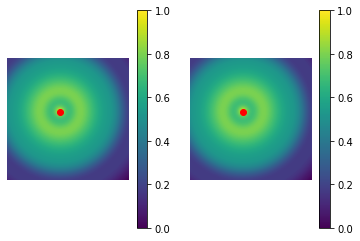

In [14]:
import cv2
import os
import matplotlib.pyplot as plt
file_path_kirk = os.path.join(os.getcwd(),'diffraction_modified_scattering_glycerol_isolated.png')
file_path_loba = os.path.join(os.getcwd(),'diffraction_modified_scattering_glycerol_isolated_lobato.png')

#print(file_path)
image_kirk = cv2.imread(file_path_kirk,0)
kirk = cv2.bitwise_not(image_kirk)
image_loba = cv2.imread(file_path_loba,0)
loba = cv2.bitwise_not(image_loba)
plt.subplot(1,2,1)
plt.imshow(kirk)
plt.scatter(xcen, ycen, color = 'red')
plt.colorbar()
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(loba)
plt.scatter(xcen, ycen, color = 'red')
plt.colorbar()
plt.axis('off')

Minimum s value = 0.020142465596894497
Maximum s value = 8.036843773160903


Text(0, 0.5, 'sM(s) (Arb-units)')

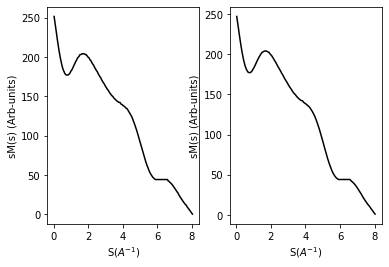

In [15]:
#azimuthal integration using the intergate1d method
#the default radial unit is “q_nm^1”, so the scattering vector length expressed in inverse nanometers. 
#To be able to calculate q, one needs to specify the wavelength used
res = ai.integrate1d(kirk, 200)

#The ds in stuart's code is calculated as ds = (2*np.pi*pixelSize*radialDist[0])/(wavel*distanceDet)
#here I believe that is done by 2*pi*pixel_size/(wavel/distanceDet)
sx_kirk = res[0]*0.1
Itot_kirk = res[1]

res_loba = ai.integrate1d(loba, 100)
sx_loba = res_loba[0]*0.1
Itot_loba = res_loba[1]

print("Minimum s value = {}".format(sx_kirk.min()))
print("Maximum s value = {}".format(sx_kirk.max()))

#Display the integration result

plt.subplot(1,2,1)
plt.plot(sx_kirk,Itot_kirk, color = 'black')
plt.xlabel('S($A^{-1}$)')
plt.ylabel('sM(s) (Arb-units)')
plt.subplot(1,2,2)
plt.plot(sx_loba,Itot_loba, color = 'black')
plt.xlabel('S($A^{-1}$)')
plt.ylabel('sM(s) (Arb-units)')

Text(0, 0.5, 'sM(s) (Arb-units)')

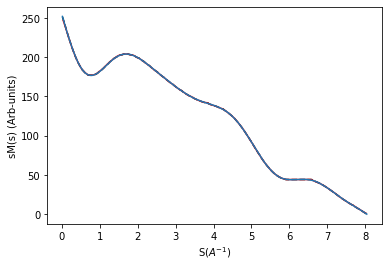

In [16]:
from scipy import signal
smooth_Itot = signal.savgol_filter(Itot_kirk, window_length=19, polyorder=3)

plt.plot(sx_kirk,Itot_kirk, color = 'black', ls = '--')
plt.plot(sx_loba,Itot_loba, color = 'red')
plt.plot(sx_kirk,smooth_Itot)
plt.xlabel('S($A^{-1}$)')
plt.ylabel('sM(s) (Arb-units)')

In [17]:
head = 'S(A^-1)'+'\t'+'sM(s)'+'\n'
text = '{}'+'\t'+'{}'+'\n'
file = open('sM(s)_vs_s.txt', 'w+')
file.write(head)
for s,I in zip(sx_kirk, smooth_Itot):
    file.write(text.format(s,I))
file.close()

Text(0, 0.5, 'Itot (Arb-units)')

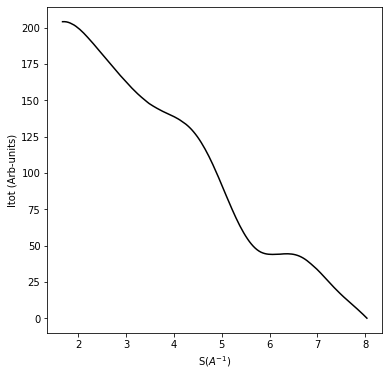

In [18]:
s_cut = []
I_cut = []
for s,I in zip(sx_kirk,smooth_Itot):
    if s>=1.65 and s<=8.7:
        s_cut.append(s)
        I_cut.append(I)
    else:
        continue
#print(s_cut)
#print(I_cut)
plt.figure(figsize=(6,6))
plt.plot(s_cut,I_cut, color = 'black')
plt.xlabel('S($A^{-1}$)')
plt.ylabel('Itot (Arb-units)')

In [19]:
#Background being subtracted after fitting the Itot to a cubic polynomial
from scipy.optimize import curve_fit
def fit_poly(x,a,b,c,d):
    y = a*x**3+b*x**2+c*x+d
    return y
popt, pcov = curve_fit(fit_poly, s_cut, I_cut)
print(popt)

[  0.94972779 -12.90681739  18.10389681 204.6449309 ]


(1.4, 9.0)

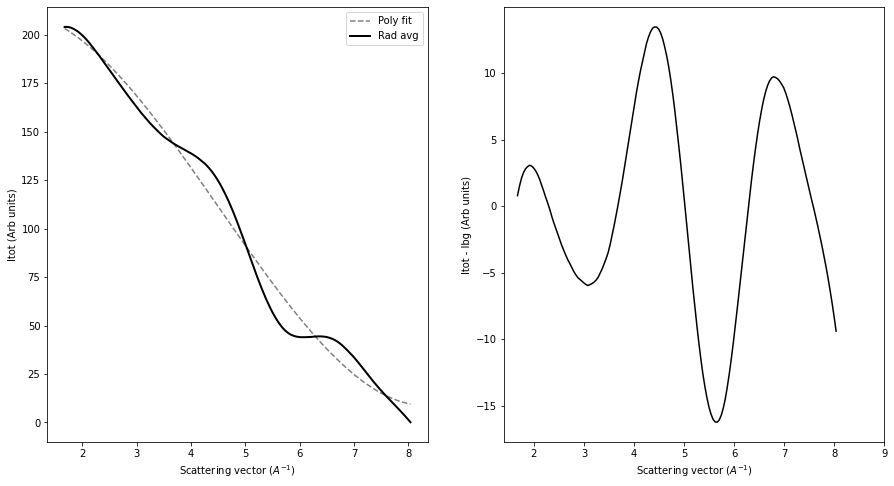

In [20]:
import numpy as np
y =[]
for item in s_cut:
    y.append(fit_poly(item,popt[0],popt[1],popt[2],popt[3]))
    
s_ms =  np.subtract(I_cut,y)

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(s_cut,y,color = 'gray', ls = '--')
plt.plot(s_cut,I_cut,color = 'black', lw =2)
plt.legend(['Poly fit','Rad avg'])
plt.ylabel('Itot (Arb units)')
plt.xlabel('Scattering vector ($A^{-1}$)')
plt.subplot(1,2,2)
plt.plot(s_cut,s_ms, color = 'black')
plt.ylabel('Itot - Ibg (Arb units)')
plt.xlabel('Scattering vector ($A^{-1}$)')
plt.xlim([1.4,9])